# MCA Analysis on Automobile Dataset 

This notebook aims to apply Multiple Correspondence Analysis (EDA) to know better [Automobile Dataset](https://www.kaggle.com/datasets/toramky/automobile-dataset/) - categorical variables - and to infer characteristics of the data which will be used into AI model training. Here we select MCA since we have multiple categorical variables.

The MCA represents categorical variable as points in multidimensional space such that we catch the maximum amount of variation.

We use the MCA for the following aims: (1) evaluate interrelations of the cars according to attribute categorical values, (2) evaluate the importance of the categorical attributes of the cars ,(3) combine PCA on numeric variables and MCA on categorical variables to build a model, (4) findings - conclusions of the MCA analysis 
 

Install/Load packages, introduce constants and load data.

In [1]:
!pip install prince

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from copy import deepcopy
import matplotlib.pyplot as plt

import numpy as np
import os 
import pandas as pd 
import prince
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2 # for chi-squared feature selection
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

In [3]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

In [4]:
PROJECT_PATHNAME = globals()['_dh'][1].resolve().parents[0]
FILE_PATHNAME = os.path.join(PROJECT_PATHNAME, 'data/Automobile_data.csv')

df =  pd.read_csv(FILE_PATHNAME)

Load car data and divide it into two quantative and categorical datasets according to attribute types. We then apply MCA analysis on categorical dataset and PCA analysis on quantative dataset. We set categorical ordinal variables into numeric, while consider a numeric 'symboling' variable as a categorical ordinal variable - target variable for MCA analysis. 

In [5]:
df.head(5)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       205 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

In [61]:
quant_attr = ["normalized-losses", "price", "wheel-base", "length", "width", "height", "curb-weight", "engine-size", "bore", "stroke", "compression-ratio",
              "horsepower", "peak-rpm", "city-mpg", "highway-mpg"]
cat_attr = ["make", "fuel-type", "aspiration", "num-of-doors", "body-style", "drive-wheels", "engine-location", "engine-type", "num-of-cylinders", "fuel-system"]

In [60]:


df[cat_attr].head(5)
df.replace('?', np.nan, inplace = True)
df_cat_attr = pd.DataFrame()
df_cat_attr[cat_attr] = df[cat_attr] 
df_cat_attr['symboling'] = df['symboling'].astype(str)


In [9]:

# See what categories there are in each categorical feature
for col in cat_attr:
    print (col, df[col].unique())
    mode_cat = df_cat_attr[col].mode()[0]
    df_cat_attr[col].fillna(mode_cat,inplace=True)
        

symboling [ 3  1  2  0 -1 -2]
make ['alfa-romero' 'audi' 'bmw' 'chevrolet' 'dodge' 'honda' 'isuzu' 'jaguar'
 'mazda' 'mercedes-benz' 'mercury' 'mitsubishi' 'nissan' 'peugot'
 'plymouth' 'porsche' 'renault' 'saab' 'subaru' 'toyota' 'volkswagen'
 'volvo']
fuel-type ['gas' 'diesel']
aspiration ['std' 'turbo']
num-of-doors ['two' 'four' nan]
body-style ['convertible' 'hatchback' 'sedan' 'wagon' 'hardtop']
drive-wheels ['rwd' 'fwd' '4wd']
engine-location ['front' 'rear']
engine-type ['dohc' 'ohcv' 'ohc' 'l' 'rotor' 'ohcf' 'dohcv']
num-of-cylinders ['four' 'six' 'five' 'three' 'twelve' 'two' 'eight']
fuel-system ['mpfi' '2bbl' 'mfi' '1bbl' 'spfi' '4bbl' 'idi' 'spdi']


#### 1. Evaluate interrelations of the cars according to attribute categorical values 

The idea is to see distribution of cars in the two main component space[[1]](https://www.displayr.com/how-correspondence-analysis-works/) [[2]](https://datascienceplus.com/selecting-categorical-features-in-customer-attrition-prediction-using-python/)

In [10]:
df[cat_attr]

,symboling,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,engine-type,num-of-cylinders,fuel-system
0,3,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
1,3,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
2,1,alfa-romero,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi
3,2,audi,gas,std,four,sedan,fwd,front,ohc,four,mpfi
4,2,audi,gas,std,four,sedan,4wd,front,ohc,five,mpfi
...,...,...,...,...,...,...,...,...,...,...,...
200,-1,volvo,gas,std,four,sedan,rwd,front,ohc,four,mpfi
201,-1,volvo,gas,turbo,four,sedan,rwd,front,ohc,four,mpfi
202,-1,volvo,gas,std,four,sedan,rwd,front,ohcv,six,mpfi
203,-1,volvo,diesel,turbo,four,sedan,rwd,front,ohc,six,idi


In [11]:
# instantiate MCA class
mca = prince.MCA(n_components = 2)
# get principal components
mca = mca.fit(df_cat_attr)
#mca = mca.transform(df[cat_attr])

# project categories onto mca components
# what we want to see is for the points belonging to the same color to be as far apart as possible, for all colors
mca.plot(df[cat_attr])

alt.Chart(...)

### 2. Evaluate the importance of the categorical attributes of the cars 

Here we apply two approaches to evaluate importance of separate categorical attributes to the target variable 'symboling' through 'chi square' test [[2]](https://datascienceplus.com/selecting-categorical-features-in-customer-attrition-prediction-using-python/). The first case the evaluation is performed with respect to certain value of the symboling, while in the second case - to the target variable itself. In both cases we aim to reduce redundancy in categorical variables and we use 'one-hot encoding' of each category of the categorical variables - predictors. 

In [12]:
df_cat_attr['symboling'] = df_cat_attr['symboling'].astype(str)
df_cat_attr_dummy = pd.get_dummies(df_cat_attr, drop_first=True)
print(df_cat_attr.shape)
print(df_cat_attr_dummy.shape)
print("Features after get_dummies:\n", list(df_cat_attr_dummy.columns))

(205, 11)
(205, 55)
Features after get_dummies:
 ['symboling_-2', 'symboling_0', 'symboling_1', 'symboling_2', 'symboling_3', 'make_audi', 'make_bmw', 'make_chevrolet', 'make_dodge', 'make_honda', 'make_isuzu', 'make_jaguar', 'make_mazda', 'make_mercedes-benz', 'make_mercury', 'make_mitsubishi', 'make_nissan', 'make_peugot', 'make_plymouth', 'make_porsche', 'make_renault', 'make_saab', 'make_subaru', 'make_toyota', 'make_volkswagen', 'make_volvo', 'fuel-type_gas', 'aspiration_turbo', 'num-of-doors_two', 'body-style_hardtop', 'body-style_hatchback', 'body-style_sedan', 'body-style_wagon', 'drive-wheels_fwd', 'drive-wheels_rwd', 'engine-location_rear', 'engine-type_dohcv', 'engine-type_l', 'engine-type_ohc', 'engine-type_ohcf', 'engine-type_ohcv', 'engine-type_rotor', 'num-of-cylinders_five', 'num-of-cylinders_four', 'num-of-cylinders_six', 'num-of-cylinders_three', 'num-of-cylinders_twelve', 'num-of-cylinders_two', 'fuel-system_2bbl', 'fuel-system_4bbl', 'fuel-system_idi', 'fuel-system_

In [13]:
X = df_cat_attr_dummy.drop('symboling_-2', axis=1) # input categorical features
y = df_cat_attr_dummy['symboling_-2'] # target variable

# categorical feature selection
sf = SelectKBest(chi2, k='all')
sf_fit = sf.fit(X, y)

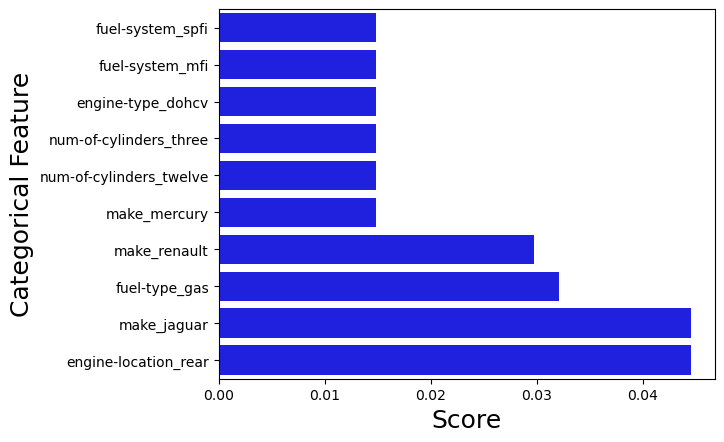

In [14]:
# plot the scores
datset = pd.DataFrame()
datset['feature'] = X.columns[ range(len(sf_fit.scores_))]
datset['scores'] = sf_fit.scores_
datset = datset.sort_values(by='scores', ascending=True)
sns.barplot(x=datset['scores'][:10], y=datset['feature'][:10], color='blue')
sns.set_style('whitegrid')
plt.ylabel('Categorical Feature', fontsize=18)
plt.xlabel('Score', fontsize=18)
plt.show()


In [15]:
X1 = df_cat_attr.drop('symboling', axis=1) # input features
y1 = df_cat_attr['symboling'] # target variable
# prepare input features
oe = OrdinalEncoder()
oe.fit(X1)
X_enc = oe.transform(X1)
# prepare target variable
le = LabelEncoder()
le.fit(y1)
y_enc = le.transform(y1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   make              205 non-null    object
 1   fuel-type         205 non-null    object
 2   aspiration        205 non-null    object
 3   num-of-doors      205 non-null    object
 4   body-style        205 non-null    object
 5   drive-wheels      205 non-null    object
 6   engine-location   205 non-null    object
 7   engine-type       205 non-null    object
 8   num-of-cylinders  205 non-null    object
 9   fuel-system       205 non-null    object
dtypes: object(10)
memory usage: 16.1+ KB
None


In [16]:
# feature selection
sf = SelectKBest(chi2, k='all')
sf_fit1 = sf.fit(X_enc, y_enc)

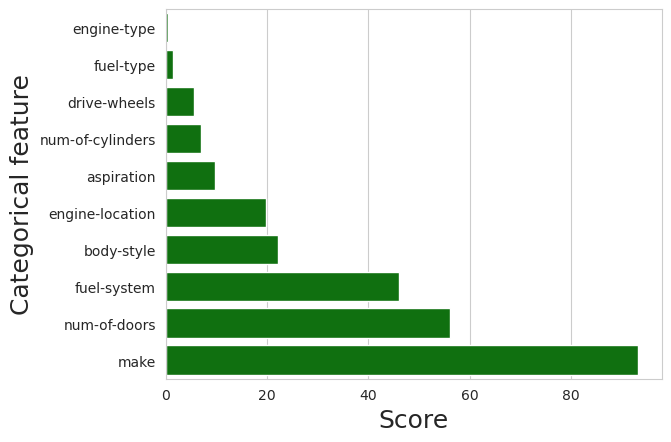

In [17]:
# plot the scores of features
datset1 = pd.DataFrame()
datset1['feature'] = X1.columns[ range(len(sf_fit1.scores_))]
datset1['scores'] = sf_fit1.scores_
datset1 = datset1.sort_values(by='scores', ascending=True)
sns.barplot(x=datset1['scores'], y=datset1['feature'], color='green')
sns.set_style('whitegrid')
plt.ylabel('Categorical feature', fontsize=18)
plt.xlabel('Score', fontsize=18)
plt.show()

#### 3. Combine PCA on numeric variables and MCA on categorical variables to build a model

This is another way to decrease redundancy in dataset - we apply PCA and MCA transform on numeric and categorical attributes from the automobile dataset [[3]](https://sinashariati.medium.com/tune-the-feature-reductions-pca-and-mca-to-build-a-model-on-a-categorical-and-numerical-data-7c27310607b8). We will use the output to train a model to predict the price of the automobile.

In [35]:
df['normalized-losses'] = df['normalized-losses'].dropna().astype(int)
df['bore'] = df['bore'].dropna().astype(float)
df['stroke'] = df['stroke'].dropna().astype(float)
df['horsepower'] = df['horsepower'].dropna().astype(int)
df['peak-rpm'] = df['peak-rpm'].dropna().astype(int)
df['price'] = df['price'].dropna().astype(int)

Apply PCA analysis on quantative attributes of the auto dataset.

In [52]:

df_quant_attr = pd.DataFrame(columns=quant_attr)

df_quant_attr[quant_attr] = df[quant_attr]
for col in quant_attr:
    print(col)
    mean_cat = df_quant_attr[col].dropna().mean()
    df_quant_attr[col].fillna(mean_cat,inplace=True)


normalized-losses
price
wheel-base
length
width
height
curb-weight
engine-size
bore
stroke
compression-ratio
horsepower
peak-rpm
city-mpg
highway-mpg


In [53]:
df_quant_attr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   normalized-losses  205 non-null    float64
 1   price              205 non-null    float64
 2   wheel-base         205 non-null    float64
 3   length             205 non-null    float64
 4   width              205 non-null    float64
 5   height             205 non-null    float64
 6   curb-weight        205 non-null    int64  
 7   engine-size        205 non-null    int64  
 8   bore               205 non-null    float64
 9   stroke             205 non-null    float64
 10  compression-ratio  205 non-null    float64
 11  horsepower         205 non-null    float64
 12  peak-rpm           205 non-null    float64
 13  city-mpg           205 non-null    int64  
 14  highway-mpg        205 non-null    int64  
dtypes: float64(11), int64(4)
memory usage: 24.1 KB


In [54]:
# instantiate PCA class
pca = prince.PCA(n_components = 6)

# get princical components
pca_2 = pca.fit(df_quant_attr)
pca_2.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,7.391,49.27%,49.27%
1,2.493,16.62%,65.89%
2,1.277,8.51%,74.40%
3,0.887,5.91%,80.32%


In [55]:

df_quant_attr_pca = pca.transform(df_quant_attr).head()
df_quant_attr_pca.head(5)

component,0,1,2,3
0,-0.608132,-1.962922,0.738740,2.387785
1,-0.487154,-1.984426,0.703164,2.443370
2,0.415942,-1.256492,-1.016500,-0.550886
3,-0.114922,-0.630642,-0.600376,-1.103709
4,1.320176,-1.448817,-0.335575,-1.190442


Apply MCA on category attributes of the auto dataset.

In [70]:
df_cat_attr = pd.DataFrame()
df_cat_attr[cat_attr] = df[cat_attr]
df_cat_attr["symboling"] = df["symboling"].astype(str)
for col in cat_attr:
    print(col)
    mode_cat = df_cat_attr[col].dropna().mode()
    df_cat_attr[col].fillna(mode_cat,inplace=True)
df_cat_attr["symboling"] = df["symboling"].astype(str)

mode_cat = df_cat_attr["symboling"].dropna().mode()
df_cat_attr["symboling"].fillna(mode_cat,inplace=True)

make
fuel-type
aspiration
num-of-doors
body-style
drive-wheels
engine-location
engine-type
num-of-cylinders
fuel-system


In [88]:
n_mca_components = 8
mca = prince.MCA(n_components = n_mca_components)
# get principal components
mca_fit = mca.fit(df_cat_attr)

mca_fit.eigenvalues_summary

df_cat_attr_mca = mca.transform(df[cat_attr])
df_cat_attr_mca

,0,1,2,3,4,5,6,7
0,0.027067,1.101739,-0.573418,-0.587381,-0.259466,0.603808,-0.521881,-0.521685
1,0.027067,1.101739,-0.573418,-0.587381,-0.259466,0.603808,-0.521881,-0.521685
2,0.047948,1.172534,-0.515398,-0.680097,-0.279436,0.219211,-0.340452,0.119550
3,-0.136990,-0.221033,-0.093394,0.025263,-0.273433,-0.676189,-0.042802,-0.300525
4,-0.435118,-0.137574,-0.071318,0.583869,-0.208093,-1.532529,-0.229054,-0.459265
...,...,...,...,...,...,...,...,...
200,-0.293151,0.139231,-0.019371,-0.077590,-0.459737,-0.039258,-0.049503,-0.213394
201,-0.477037,0.084306,0.125587,-0.089111,-0.256695,-0.037685,-0.289625,-0.312562
202,-0.456342,0.800114,-0.283923,-0.315548,-0.687919,-0.171518,-0.084890,0.125415
203,-1.154214,0.190053,0.611638,-0.116317,0.020468,-0.012215,-0.121419,-0.483297


In [89]:

pd_lst = [df_quant_attr_pca, df_cat_attr_mca]
df_transform = pd.concat(pd_lst, ignore_index=True, axis=1)
df_transform.head(5)
#df_transform.columns

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.608132,-1.962922,0.738740,2.387785,0.027067,1.101739,-0.573418,-0.587381,-0.259466,0.603808,-0.521881,-0.521685
1,-0.487154,-1.984426,0.703164,2.443370,0.027067,1.101739,-0.573418,-0.587381,-0.259466,0.603808,-0.521881,-0.521685
2,0.415942,-1.256492,-1.016500,-0.550886,0.047948,1.172534,-0.515398,-0.680097,-0.279436,0.219211,-0.340452,0.119550
3,-0.114922,-0.630642,-0.600376,-1.103709,-0.136990,-0.221033,-0.093394,0.025263,-0.273433,-0.676189,-0.042802,-0.300525
4,1.320176,-1.448817,-0.335575,-1.190442,-0.435118,-0.137574,-0.071318,0.583869,-0.208093,-1.532529,-0.229054,-0.459265


#### 4. Findings
From the analysis in this notebook we reached the following conclusions:
- we can use MCA algorithm for exploratory analysis of the categorical data
- we can use chi-square + MCA analysis to evaluate intra correlation/importance between categorical variables - we evaluated importance of all categorical features to 'symboling'. Thus we can use it for dimensionality reduction but not to evaluate importance of categorical features to a numeric feature as 'Price'
- we can compute components of categorical data through MCA analysis similar to those computed through PCA analysis on numeric data. We can combine both of them to apply after that a regression algorithm for prediction of a numeric variable.
